# Analysis of Neuron Selectivity for DRD87 in EPM, NO, & POPP

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
from analysis import sig_proc
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == labels[0]])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[1]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[2]]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == labels[3]]))
    
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


## We begin by preprocessing the data for DRD87 in EPM.

### We import the csv of raw neuron signal data (collected during EPM experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [5]:
DRD87_EPM_DATA = pd.read_csv(raw_files[7], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_EPM_DATA, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

DRD87_EPM_behavior_df = pd.read_csv(raw_files[8], header=None)
drd87_epm_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_EPM_behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



### Now, we compute the actual difference of means, $\hat{D}$, values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe`

In [6]:
epm_real_diff_vals = drd87_epm_fe.set_real_diff_df(drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69,neuron70
D,5.72857,-3.00185,-1.36973,12.1606,-0.555661,-3.64355,8.0656,-3.7702,-0.683886,-3.68069,...,3.74837,-0.92522,0.176564,0.569157,-1.74818,0.711728,1.67555,1.55181,1.89085,4.47428


### Next, we create the permutation distributions of the difference of means, $\hat{D}$, values for each neuron, with $\ge 10000$ permutation resamples.
### Immediately after we create our permutation distributions, we plot the distribution for each neuron.

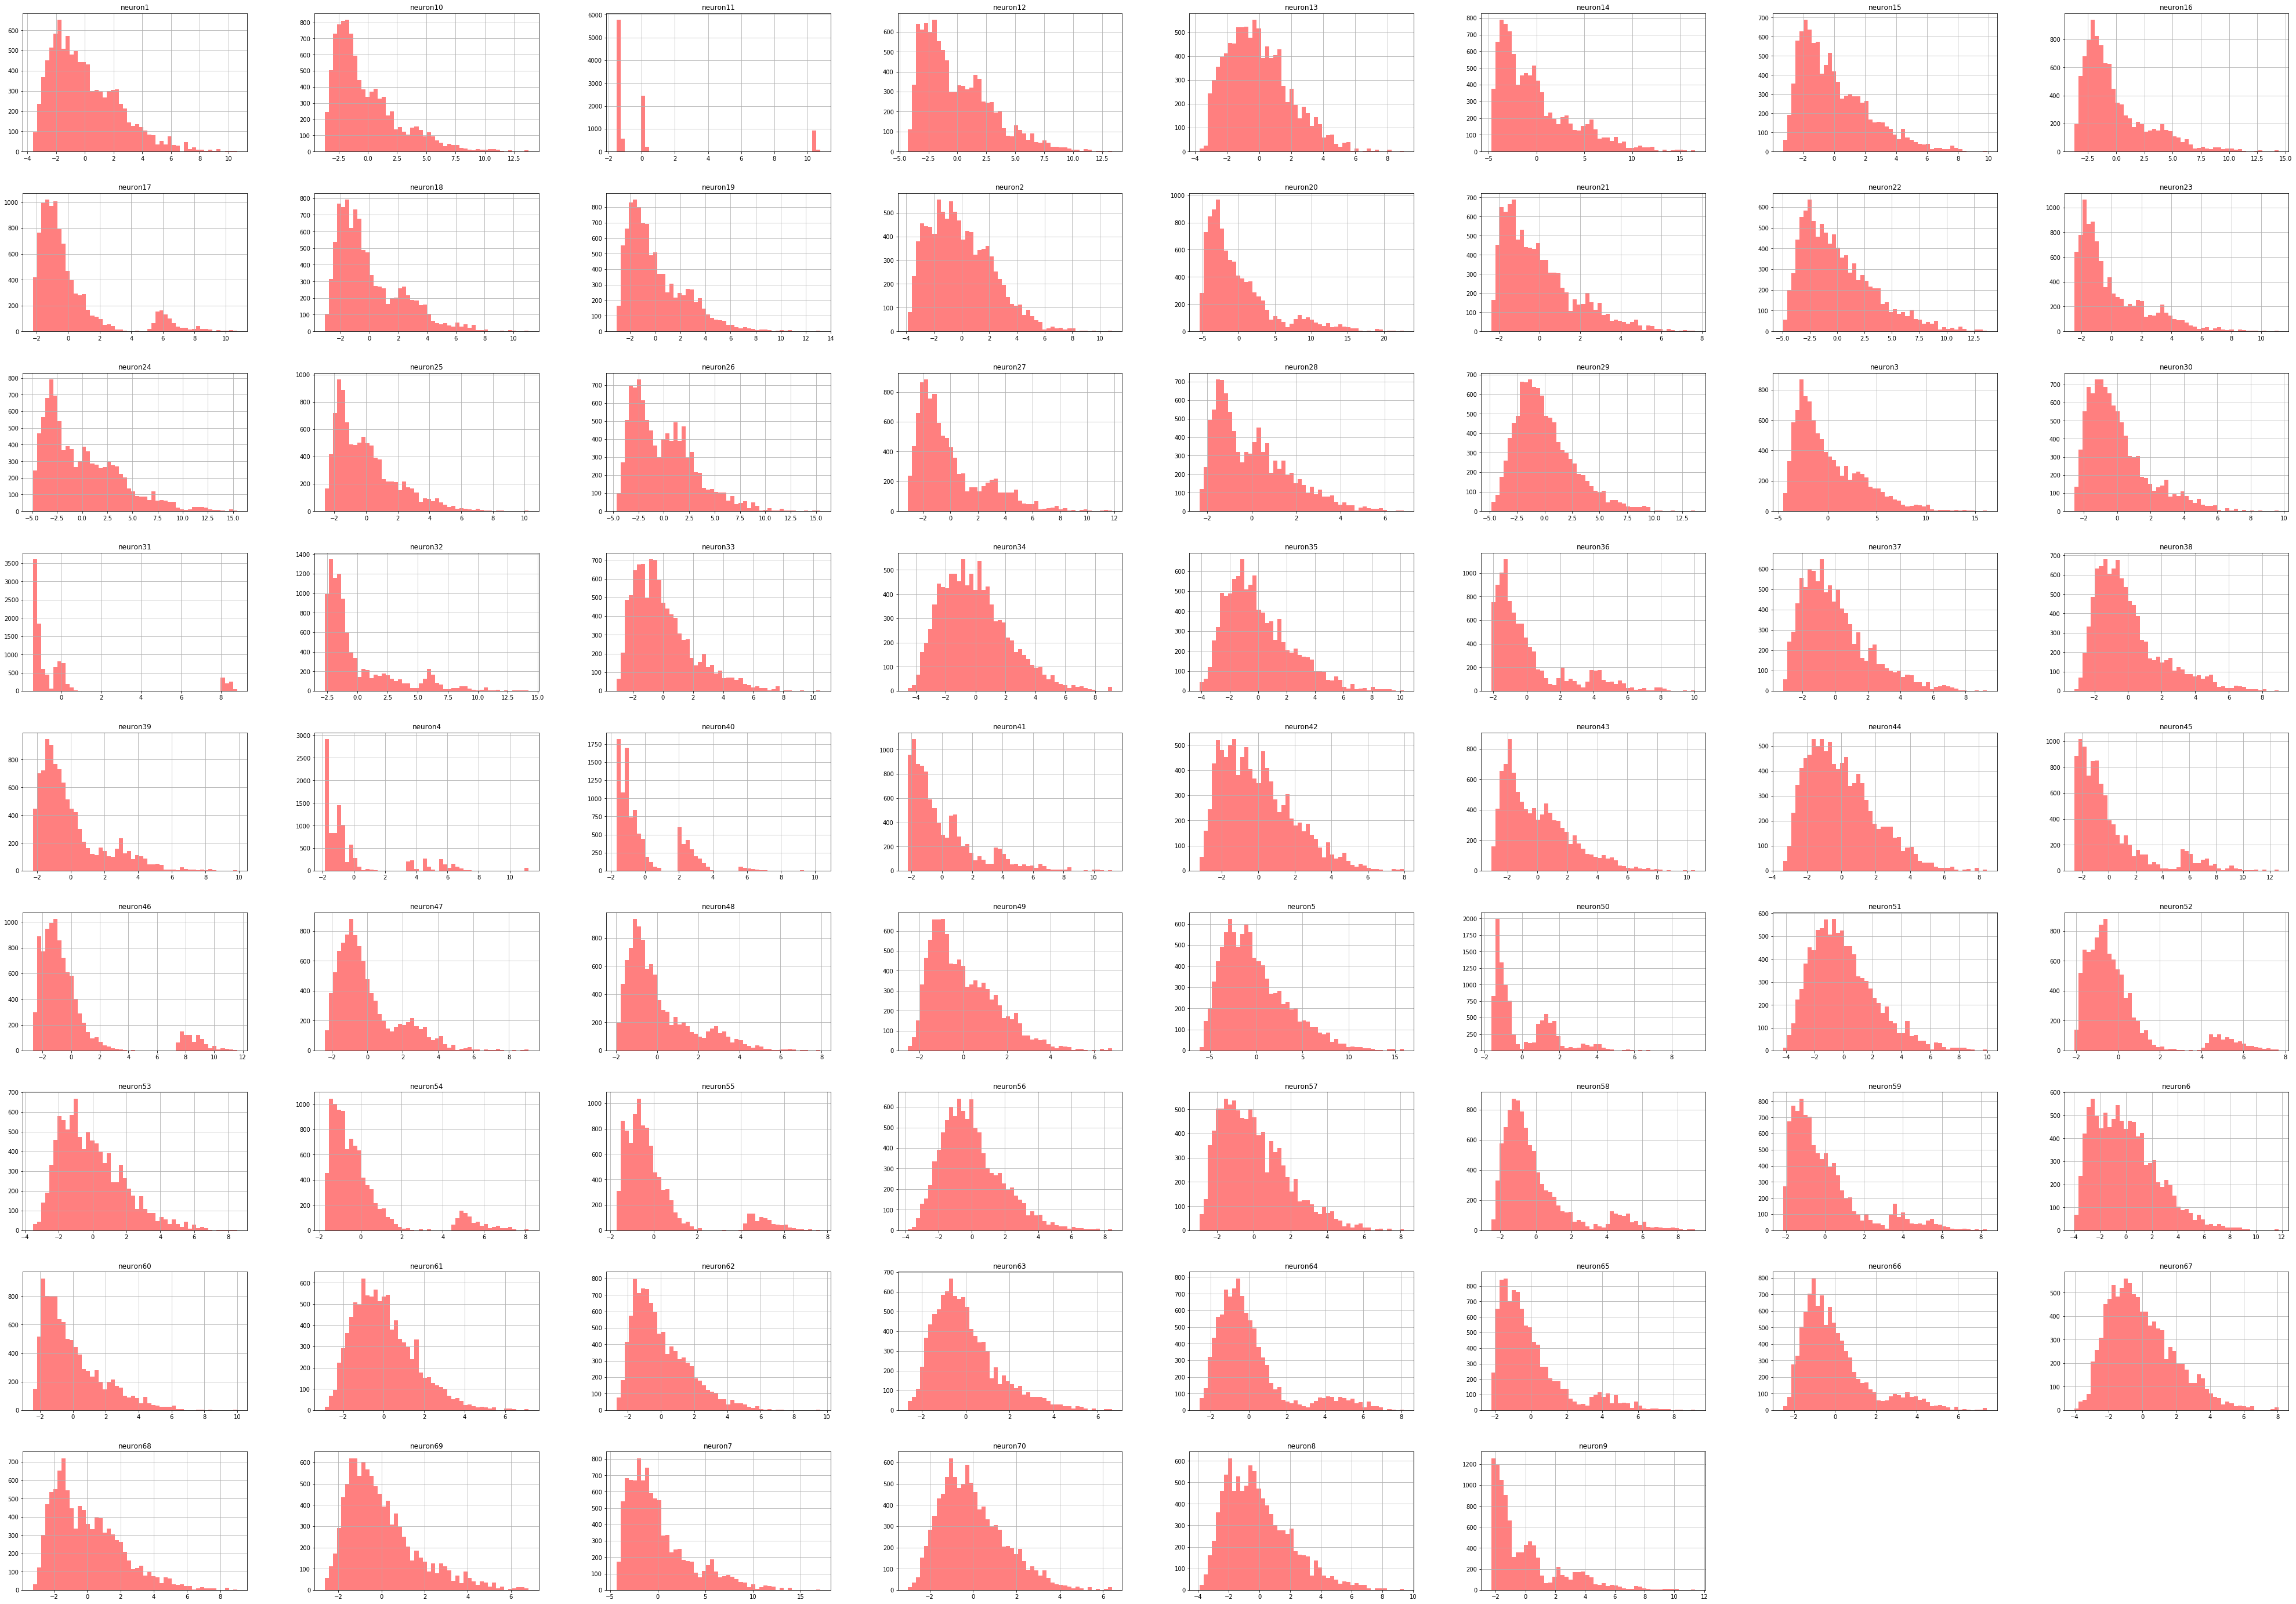

In [7]:
epm_resampled_df = Resampler.shuffle(10000, drd87_epm_fe.neuron_concated_behavior, drd87_epm_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
epm_resampled_df.hist(alpha=0.5, color="red", bins=50, figsize=(70, 50));

### Finally, we actually execute the **permuation test**, where we classify neurons as either *selective*, or *not-selective*, or *unclassified*.

### After classifying the neurons as either selective, not-selective, or unclassified, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for **OpenArms_centerpoint**. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for **ClosedArms_centerpoint**.

In [8]:
epm_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_epm_fe.auc_df, epm_resampled_df, epm_real_diff_vals, p_value=0.1, threshold=5)
epm_neurons_for_beh = Resampler.classify_by_behavior(epm_classified_neurons, epm_real_diff_vals, "OpenArms_centerpoint", "ClosedArms_centerpoint")

In [9]:
plot_pie_chart(epm_neurons_for_beh, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

## Now, for the analysis of data collected during POPP, we preprocess the data for DRD87.

### We import the csv of raw neuron signal data (collected during POPP experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [10]:
DRD87_POPP_DATA = pd.read_csv(raw_files[3], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_POPP_DATA, 2, 0.5, 0.2, 10)

DRD87_POPP_behavior_df = pd.read_csv(raw_files[1])
DRD87_POPP_behavior_df.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
DRD87_POPP_behavior_df.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Odor_centerpoint", "Neutral_centerpoint", "Odor_Cup_centerpoint", "Neutral_Cup_centerpoint"]

drd87_popp_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_POPP_behavior_df, row_multiple=2)

### Now, we compute the actual difference of means, $\hat{D}$, values for all of the neurons in DRD87's `neuron_concated_behavior` dataframe

In [11]:
popp_real_diff_vals = drd87_popp_fe.set_real_diff_df(drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron66,neuron67,neuron68,neuron69,neuron70,neuron71,neuron72,neuron73,neuron74,neuron75
D,1.92008,4.25264,-3.09435,0.676467,7.49938,-2.32122,4.86393,-2.69076,3.83389,5.27693,...,1.56782,2.88715,2.84779,-0.912353,0.786862,-0.342486,1.66577,4.07939,2.27167,0.907633


### Next, we create the permutation distributions of the difference of means, $\hat{D}$, values for each neuron, with $\ge 10000$ permutation resamples.
### Immediately after we create our permutation distributions, we plot the distribution for each neuron.

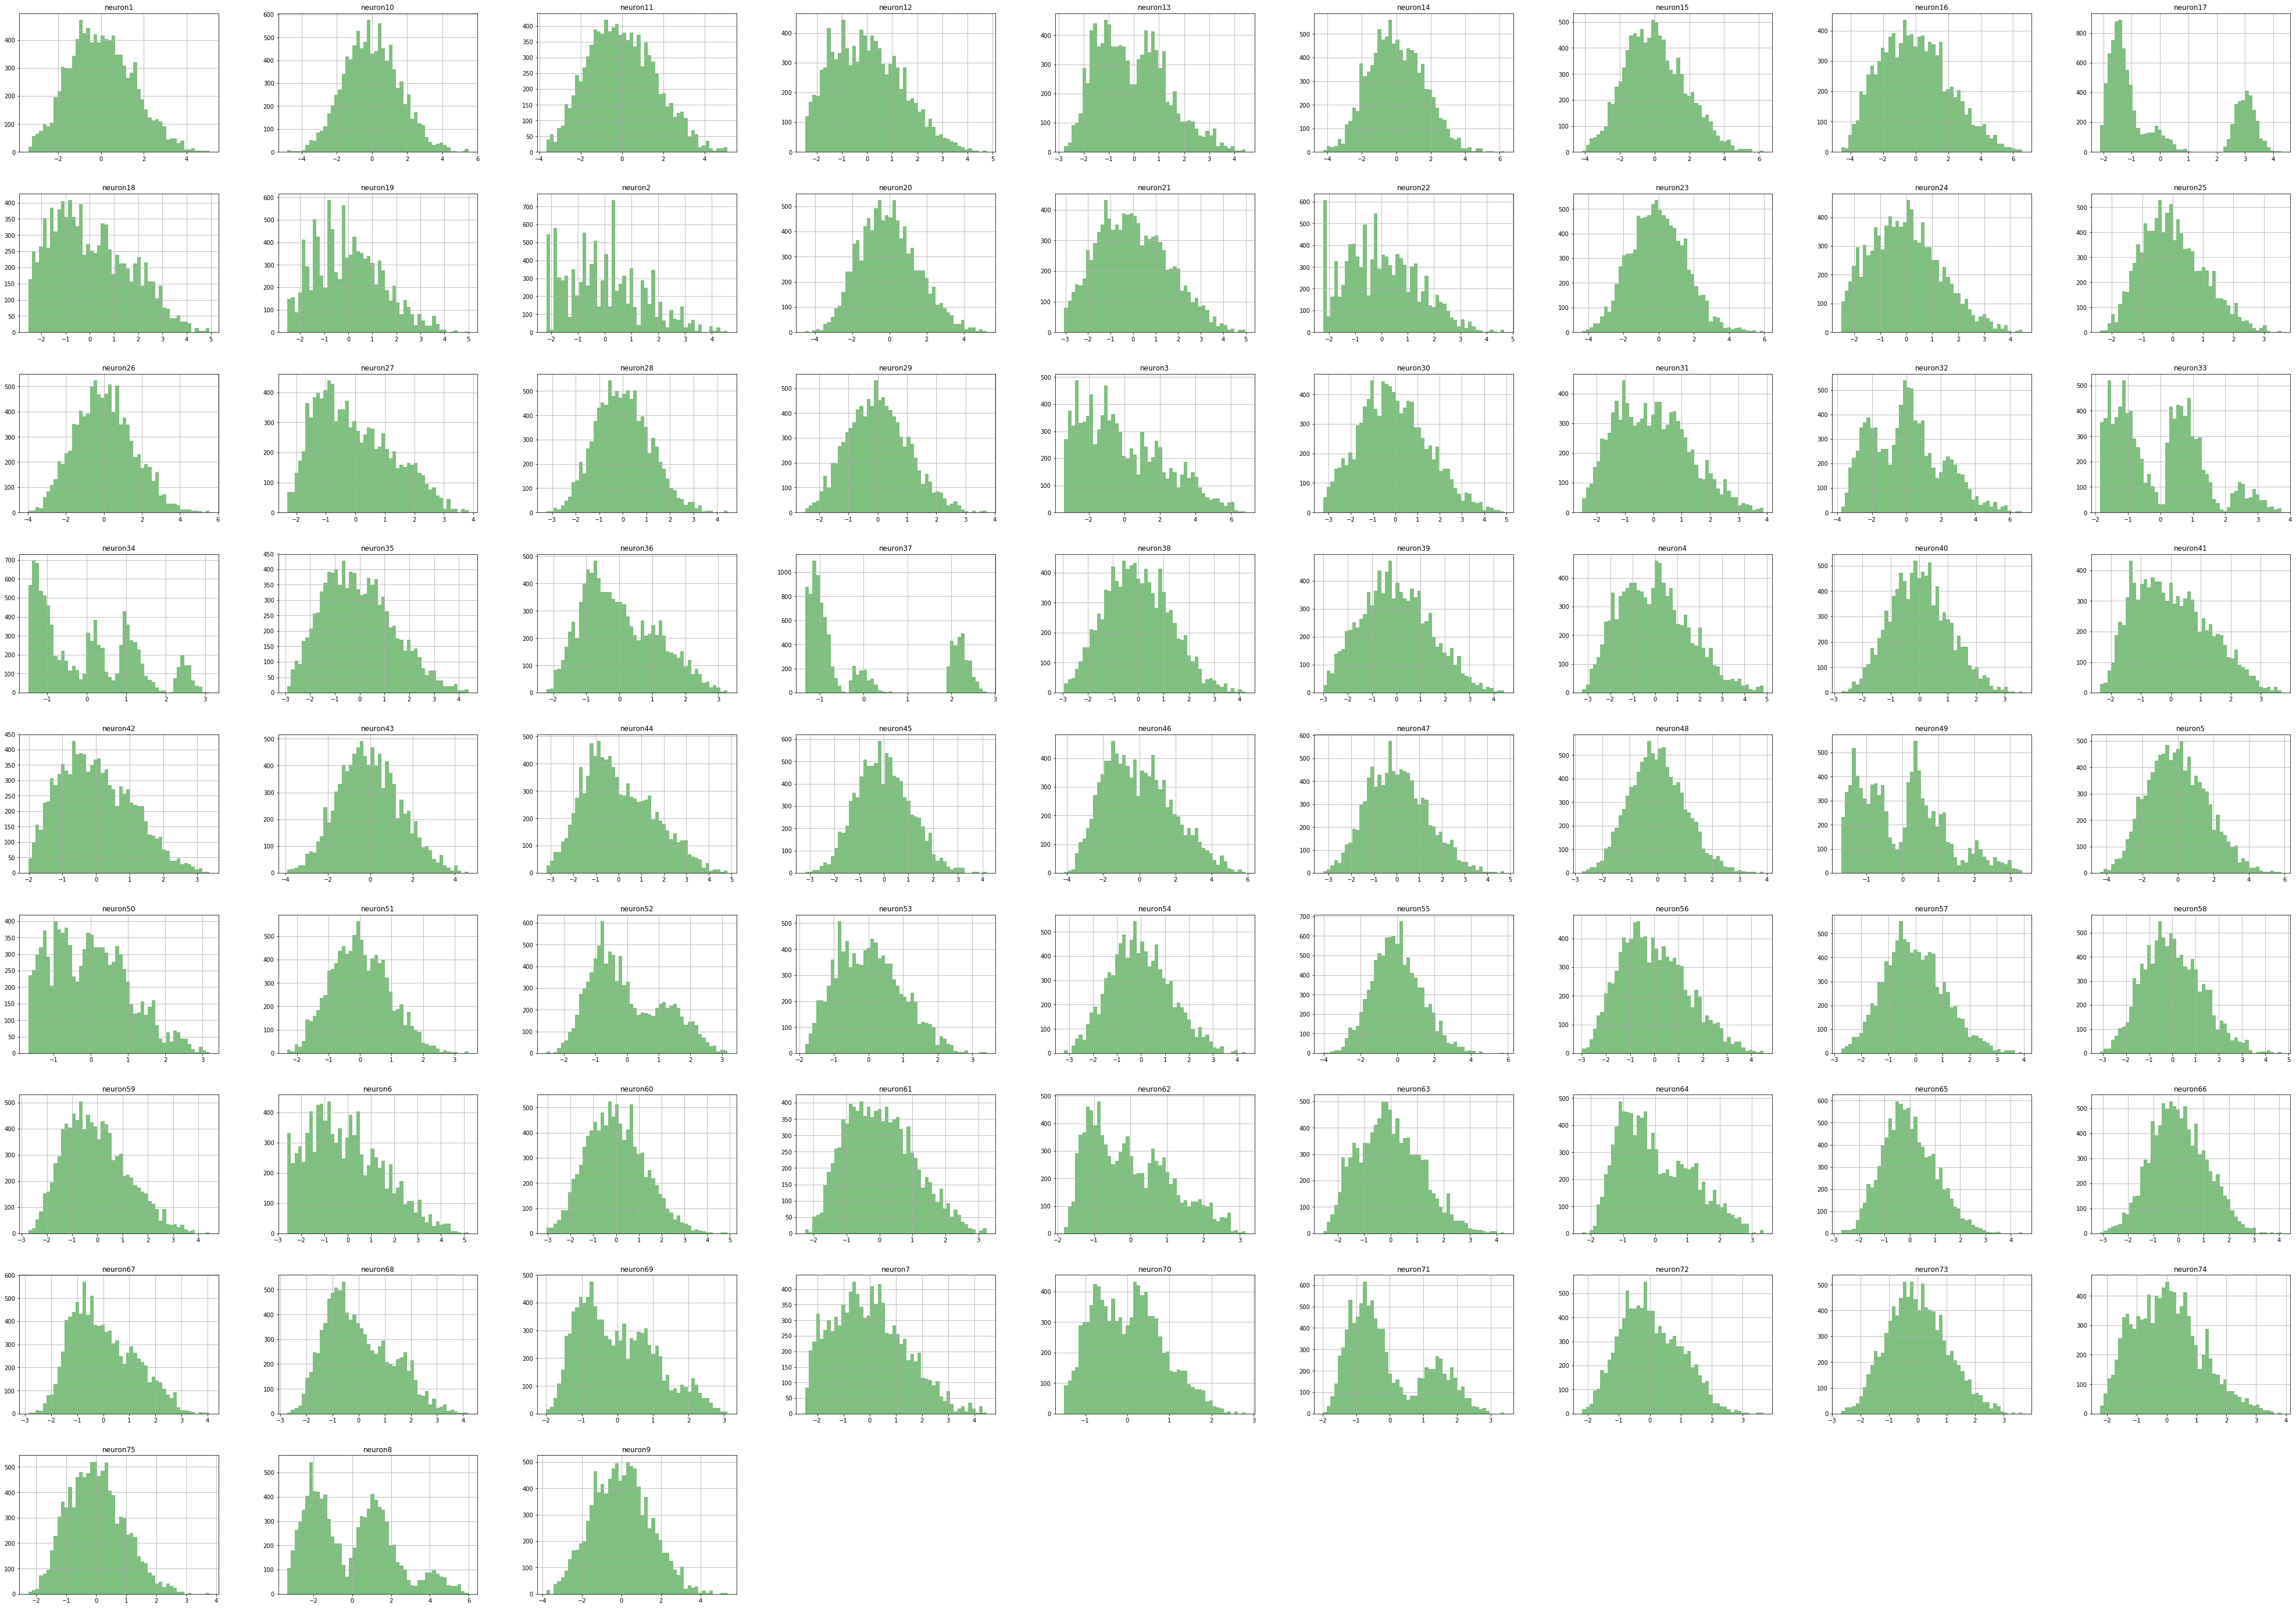

In [12]:
popp_resampled_df = Resampler.shuffle(10000, drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")
popp_resampled_df.hist(alpha=0.5, color='green', bins=50, figsize=(70, 50));

In [13]:
popp_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_popp_fe.auc_df, popp_resampled_df, popp_real_diff_vals, p_value=0.1, threshold=5)
popp_neurons_for_beh = Resampler.classify_by_behavior(popp_classified_neurons, popp_real_diff_vals, "Odor_centerpoint", "Neutral_centerpoint")

# For the purposes of analysing neurons across different experiments, we read in the neuron dictionary into a dataframe, where each column is the identity of the neuron during a particular experiment. 

In [14]:
neuron_dictionary = pd.read_csv("~/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv", header=None)
neuron_dictionary.columns = ["EPM", "NO", "OFT", "POPP"]

In [22]:
neuron_dictionary

,EPM,NO,OFT,POPP
0,1,0,0,52
1,2,49,33,23
2,3,48,21,20
3,4,3,50,2
4,5,0,4,0
5,6,0,0,0
6,7,21,0,0
7,8,11,0,53
8,9,0,0,0
9,10,13,0,18


### Next, we create a dictionary that will translate the name of the neuron imaged during POPP to the same neuron's name during EPM.

In [25]:
def create_neuron_dict(neuron_dictionary, **kwargs):
    neuron_dict = dict()
    from_this = kwargs.get("from_this")
    to_this = kwargs.get("to_this")
        
    if from_this is None or to_this is None:
        raise ValueError("You did not provide the name of experiment1 or experiment2")
    
    for row in neuron_dictionary.itertuples():
        exp_1_neuron = getattr(row, from_this)
        exp_2_neuron = getattr(row, to_this)
    
        if exp_1_neuron == 0:
            # print("Neuron {} was not active during POPP".format(exp_2_neuron))
            continue

        neuron_dict["neuron"+str(exp_1_neuron)] = "neuron"+str(exp_2_neuron)

    return neuron_dict

In [32]:
popp_to_epm = create_neuron_dict(neuron_dictionary, from_this="POPP", to_this="EPM")

In [34]:
epm_to_popp = create_neuron_dict(neuron_dictionary, from_this="EPM", to_this="POPP")

#### We know that a grand total of $123$ neurons, in DRD87, were imaged over all 4 experiments. 

In [38]:
total_amount_neurons = len(neuron_dictionary.index)
total_amount_neurons

123

### We want to know the proportion of overlap of "OpenArms_centerpoint" selective neurons, and "Odor_centerpoint" selective cells.

In [42]:
odor_open_selective = 0
for neuron in popp_neurons_for_beh:
    if popp_neurons_for_beh[neuron] == "Odor_centerpoint":
        
        if popp_to_epm[neuron] != "neuron0":
            if epm_neurons_for_beh[popp_to_epm[neuron]] == "OpenArms_centerpoint":
                print("{} ({} during EPM) was also selective for OpenArms_centerpoint in EPM".format(neuron, popp_to_epm[neuron]))
                odor_open_selective += 1
                
print("\n{}% of DRD87's neurons were selective for Odor_centerpoint AND OpenArms_centerpoint".format((odor_open_selective / total_amount_neurons) * 100))

neuron2 (neuron4 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron19 (neuron39 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron21 (neuron19 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron34 (neuron48 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron38 (neuron41 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron44 (neuron58 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron55 (neuron30 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron58 (neuron61 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron74 (neuron38 during EPM) was also selective for OpenArms_centerpoint in EPM

7.317073170731707% of DRD87's neurons were selective for Odor_centerpoint AND OpenArms_centerpoint


### How does this compare to the chance level of overlap? For example, if $30\%$ neurons are EPM selective, and $50\%$ are odor selective, We would expect $0.3 \cdot 0.5 = 0.15 = 15\%$ of the neurons that are found in both, EPM and POPP, to be selective for both "OpenArms_centerpoint" and "Odor_centerpoint".

In [81]:
open_selective_count = 0
for neuron in epm_neurons_for_beh:
    if epm_neurons_for_beh[neuron] == "OpenArms_centerpoint":
        # print(neuron)
        open_selective_count += 1

print("\n{} of DRD87's neurons were selective for OpenArms_centerpoint".format(open_selective_count))
print("{}% of DRD87's neurons were selective for OpenArms_centerpoint".format((open_selective_count / total_amount_neurons) * 100))


27 of DRD87's neurons were selective for OpenArms_centerpoint
21.951219512195124% of DRD87's neurons were selective for OpenArms_centerpoint


In [45]:
odor_selective_count = 0
for neuron in popp_neurons_for_beh:
    if popp_neurons_for_beh[neuron] == "Odor_centerpoint":
        # print(neuron)
        odor_selective_count += 1

print("\n{} of DRD87's neurons were selective for Odor_centerpoint".format(odor_selective_count))
print("{}% of DRD87's neurons were selective for Odor_centerpoint".format((odor_selective_count / total_amount_neurons) * 100))


39 of DRD87's neurons were selective for Odor_centerpoint
31.70731707317073% of DRD87's neurons were selective for Odor_centerpoint


### Does the identity of a cell in EPM correlate with the activity of the cell in POPP? In other words, for open-selective neurons, what is the rate in odor vs. non-odor?

In [46]:
import warnings 

def activity_by_neurons(concated_df, neuron_names, *behaviors, **kwargs):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: DataFrame
        
            A concatenated pandas DataFrame of the neuron activity and 
            the corresponding behavior, for a given animal.
        
        neuron_names: list
        
            The names of the neurons whose rates are to be computed.
        
        behaviors: 
            
            The behaviors for which to compute the activity rates. 
        
        frame_rate: int, optional
        
            The framerate to multiply the activity rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    frame_rate = kwargs.get("frame_rate", None)
    if frame_rate is None:
        warnings.warn("You did not specify a frame rate, so a frame rate"
                      + " of 10 will be utilized in the computation", Warning)
        frame_rate = 10
        
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

### Does the identity of a neuron in EPM correlate with the activity of the cell in POPP? In other words, for open-selective cells, what is the rate in odor vs non-odor?

In [47]:
drd87_popp_neuron_activity = activity_by_neurons(drd87_popp_fe.neuron_concated_behavior, drd87_popp_fe.auc_df.columns, "Odor_centerpoint", "Neutral_centerpoint")

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



In [67]:
selective_neuron_names = []
selective_odor_rates = []
selective_neutral_rates = []

for neuron in epm_neurons_for_beh:
    if epm_neurons_for_beh[neuron] == "OpenArms_centerpoint":
        if epm_to_popp[neuron] != "neuron0":
            # print("\nEPM neuron: {}".format(neuron))
            selective_neuron_names.append(neuron)
            # print("Rate in Odor_centerpoint: {}".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron], "Odor_centerpoint"]))
            selective_odor_rates.append(drd87_popp_neuron_activity.loc[epm_to_popp[neuron], "Odor_centerpoint"])
            # print("Rate in Neutral_centerpoint: {}".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron], "Neutral_centerpoint"]))
            selective_neutral_rates.append(drd87_popp_neuron_activity.loc[epm_to_popp[neuron], "Neutral_centerpoint"])

### Does the identity of a neuron in EPM correlate with the activity of the cell in POPP? In other words, for not-selective neurons, what is the rate in odor vs. non-odor?

In [68]:
not_selective_neuron_names = []
not_selective_odor_rates = []
not_selective_neutral_rates = []

for neuron in epm_neurons_for_beh:
    if epm_neurons_for_beh[neuron] == "not-selective":
        if epm_to_popp[neuron] != "neuron0":
            #print("\nEPM neuron: {}".format(epm_to_popp_dict[neuron]))
            not_selective_neuron_names.append(neuron)
            #print("Rate in Odor_centerpoint: {}".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron], "Odor_centerpoint"]))
            not_selective_odor_rates.append(drd87_popp_neuron_activity.loc[epm_to_popp[neuron], "Odor_centerpoint"])
            #print("Rate in Neutral_centerpoint: {}".format(drd87_popp_neuron_activity.loc[epm_to_popp_dict[neuron], "Neutral_centerpoint"]))
            not_selective_neutral_rates.append(drd87_popp_neuron_activity.loc[epm_to_popp[neuron], "Neutral_centerpoint"])

In [69]:
trace0 = go.Scatter(
    x = selective_neutral_rates,
    y = selective_odor_rates,
    text = selective_neuron_names,
    mode = "markers",
    name = "EPM Selective Neurons",
    marker = dict(
        color = "rgb(0, 0, 255)"
    )
)
trace1 = go.Scatter(
    x = not_selective_neutral_rates,
    y = not_selective_odor_rates,
    text = not_selective_neuron_names,
    mode = "markers",
    name = "EPM Not-Selective Neurons",
    marker = dict(
        color = "rgb(255, 0, 0)"
    )
)

data = [trace0, trace1]
layout = go.Layout(
    width=800,
    height=800,
    title="Odor vs. Non-Odor rates in EPM neurons",
)
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)

## Finally, for the analysis of data collected during POPP, we preprocess the data for DRD87.

### We import the csv of raw neuron signal data (collected during POPP experiment) into a pandas DataFrame, and run the data through the Dombeck 2007 signal processing algorithm.

In [70]:
DRD87_NO_DATA = pd.read_csv(raw_files[6], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(DRD87_NO_DATA, 2, 0.5, 0.2, 10)

DRD87_NO_behavior_df = pd.read_csv(raw_files[5])
DRD87_NO_behavior_df.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
DRD87_NO_behavior_df.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Novel_Object_centerpoint", "Neutral_Zone_centerpoint"]

drd87_no_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=DRD87_NO_behavior_df)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [71]:
no_real_diff_vals = drd87_popp_fe.set_real_diff_df(drd87_no_fe.neuron_concated_behavior, drd87_no_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron43,neuron44,neuron45,neuron46,neuron47,neuron48,neuron49,neuron50,neuron51,neuron52
D,-0.982822,1.89006,-4.61537,-6.23302,0.826767,2.46959,-2.97508,2.17559,-11.8144,0.669313,...,0.192681,1.96007,0.9887,-1.45949,-3.65233,-1.99966,-5.82677,-6.80028,-3.72449,2.22875


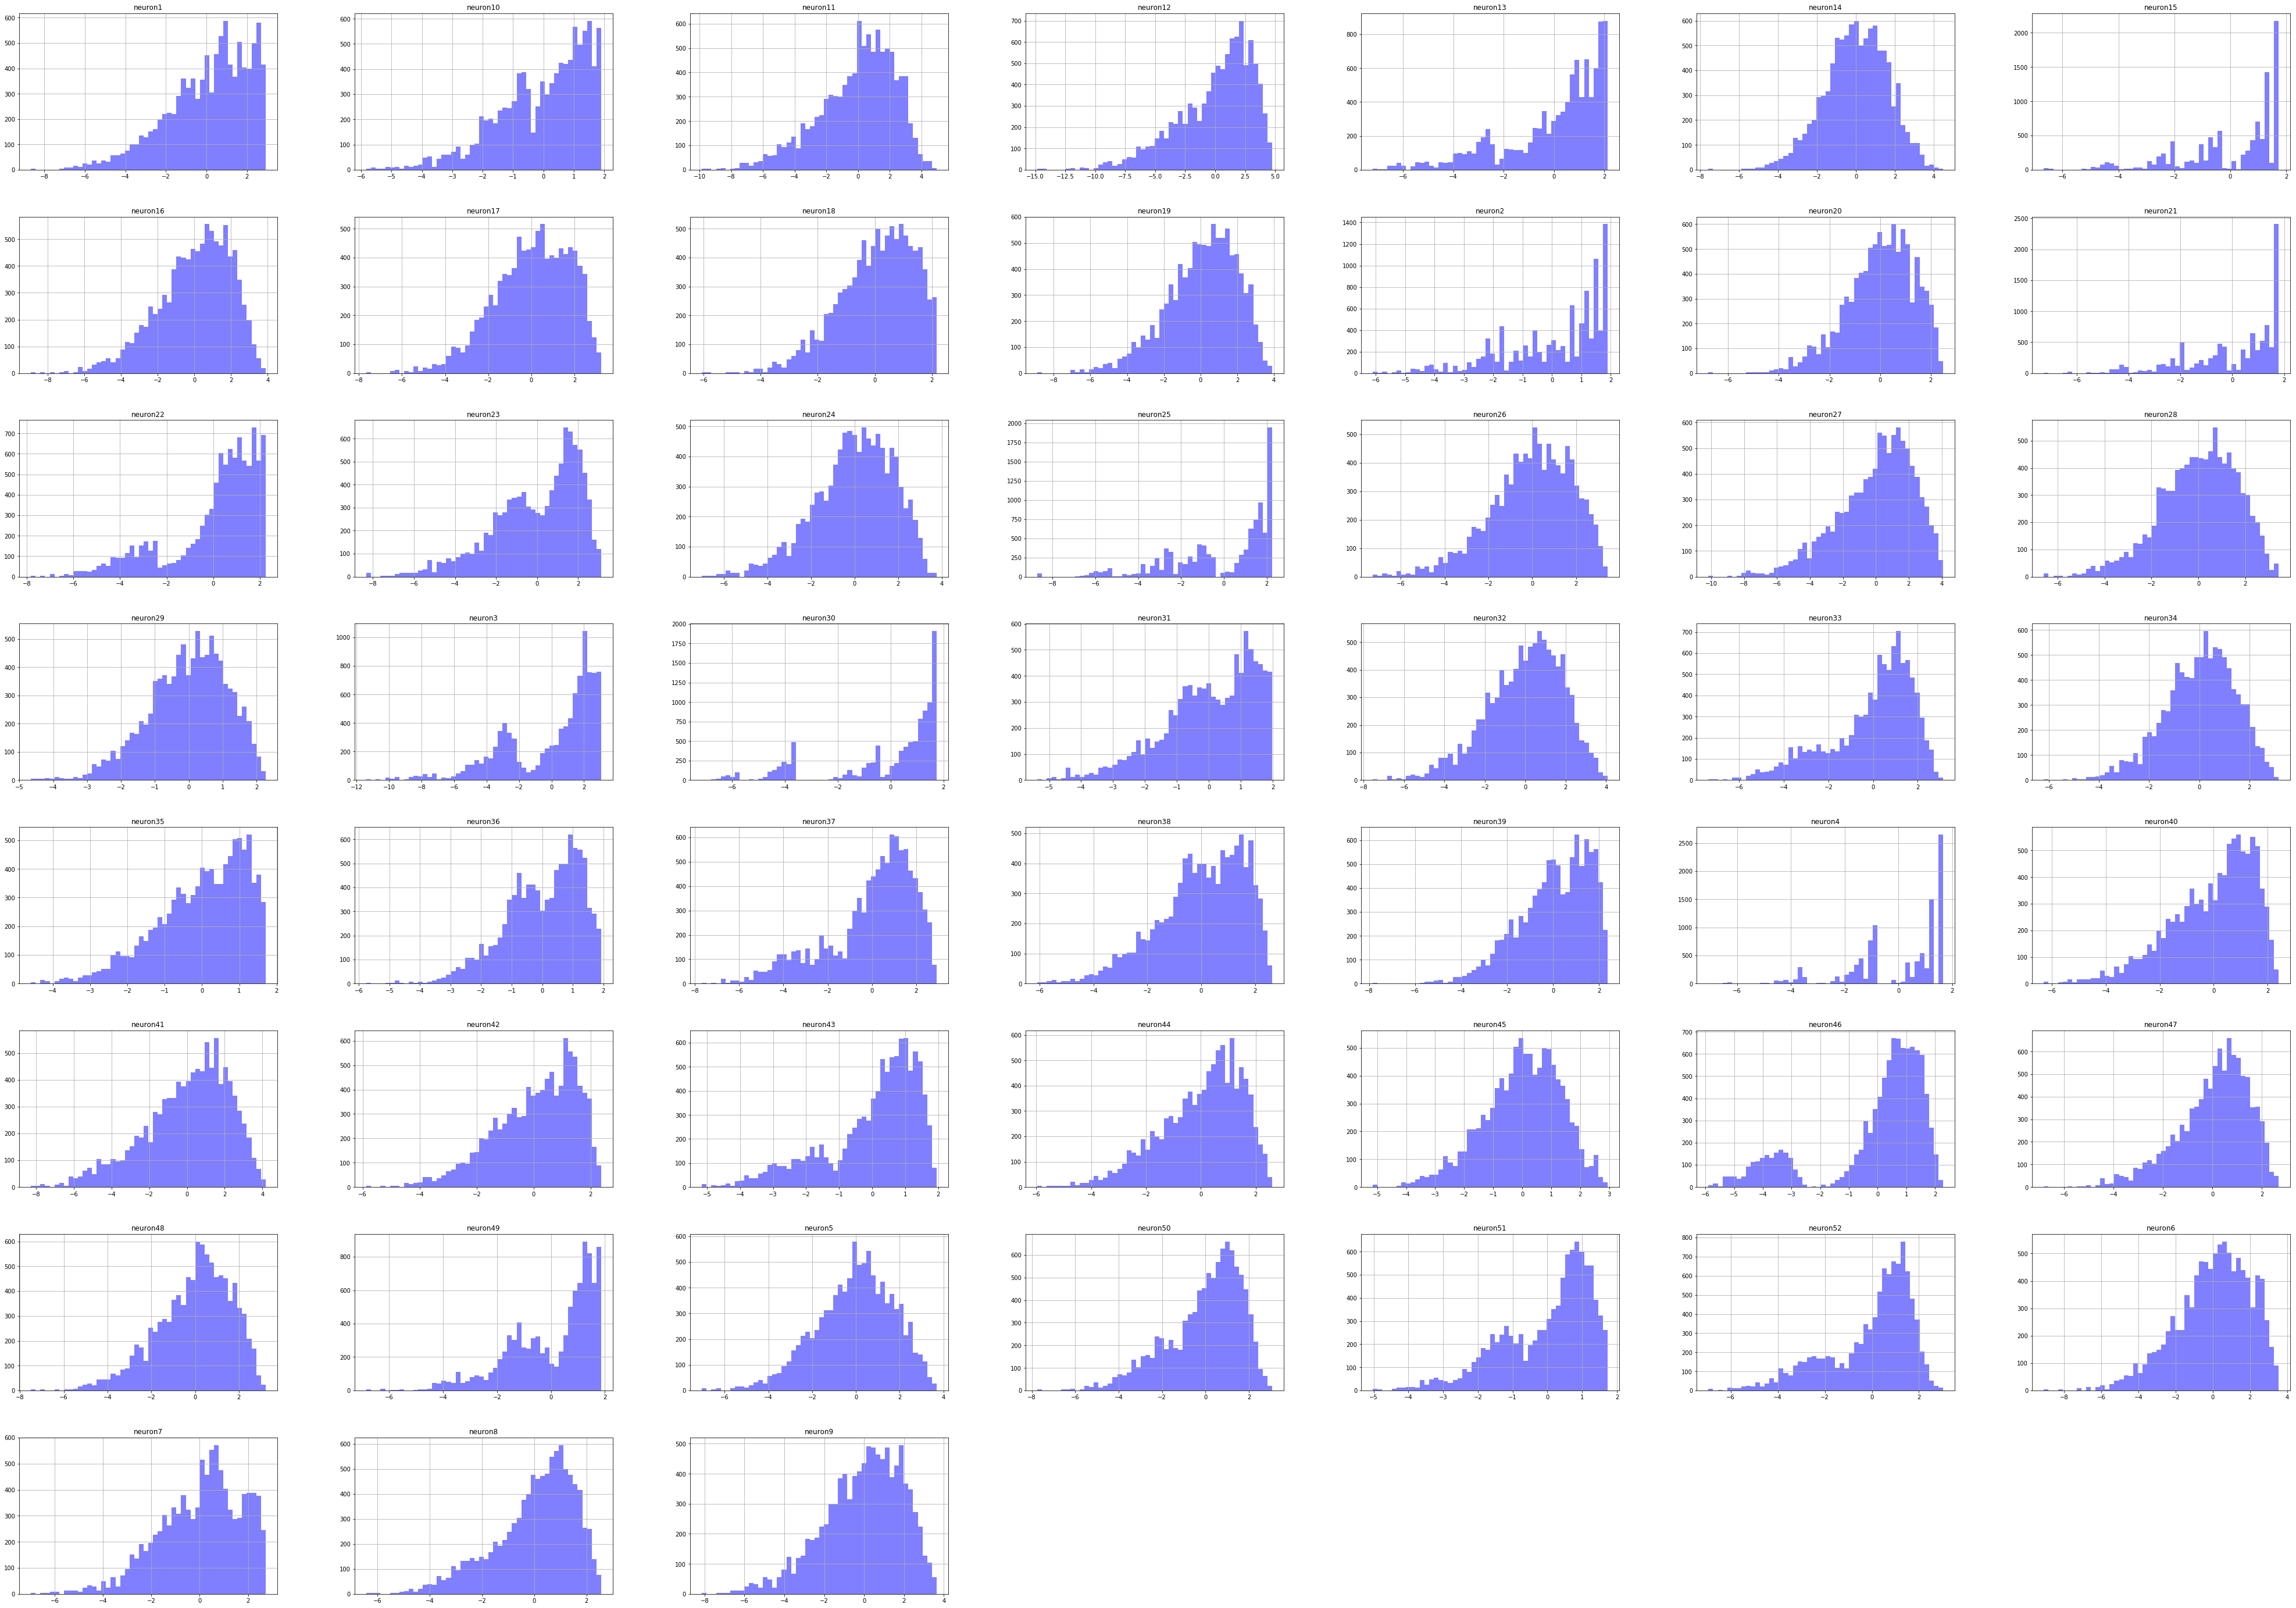

In [72]:
no_resampled_df = Resampler.shuffle(10000, drd87_no_fe.neuron_concated_behavior, drd87_no_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_resampled_df.hist(alpha=0.5, color="blue", bins=50, figsize=(70, 50));

In [75]:
no_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_popp_fe.auc_df, popp_resampled_df, popp_real_diff_vals, p_value=0.1, threshold=5)
no_neurons_for_beh = Resampler.classify_by_behavior(drd87_classified_neurons, popp_real_diff_vals, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")

In [83]:
epm_to_no = create_neuron_dict(neuron_dictionary, from_this="EPM", to_this="NO")
no_to_epm = create_neuron_dict(neuron_dictionary, from_this="NO", to_this="EPM")

In [84]:
no_to_epm

{'neuron49': 'neuron2',
 'neuron48': 'neuron3',
 'neuron3': 'neuron4',
 'neuron21': 'neuron7',
 'neuron11': 'neuron8',
 'neuron13': 'neuron10',
 'neuron4': 'neuron11',
 'neuron34': 'neuron14',
 'neuron22': 'neuron15',
 'neuron39': 'neuron16',
 'neuron35': 'neuron17',
 'neuron30': 'neuron18',
 'neuron52': 'neuron20',
 'neuron9': 'neuron23',
 'neuron6': 'neuron25',
 'neuron19': 'neuron26',
 'neuron29': 'neuron28',
 'neuron8': 'neuron30',
 'neuron40': 'neuron31',
 'neuron32': 'neuron35',
 'neuron1': 'neuron36',
 'neuron50': 'neuron38',
 'neuron26': 'neuron41',
 'neuron31': 'neuron42',
 'neuron37': 'neuron47',
 'neuron15': 'neuron48',
 'neuron18': 'neuron49',
 'neuron36': 'neuron50',
 'neuron7': 'neuron53',
 'neuron17': 'neuron57',
 'neuron51': 'neuron64',
 'neuron16': 'neuron65',
 'neuron2': 'neuron0',
 'neuron5': 'neuron0',
 'neuron10': 'neuron0',
 'neuron12': 'neuron0',
 'neuron14': 'neuron0',
 'neuron20': 'neuron0',
 'neuron23': 'neuron0',
 'neuron24': 'neuron0',
 'neuron25': 'neuron0'

### We want to know the proportion of overlap of "OpenArms_centerpoint" selective neurons, and "Novel_Object_centerpoint" selective neurons.

In [102]:
no_open_count = 0
for neuron in no_neurons_for_beh:
    
    # Make sure the neuron was selective for Novel Object
    if no_neurons_for_beh[neuron] == "Novel_Object_centerpoint":
        
        # Now make sure the neuron was also selective for Open Arms
        if no_to_epm.get(neuron) is not None and no_to_epm[neuron] != "neuron0":
            if epm_neurons_for_beh[no_to_epm[neuron]] == "OpenArms_centerpoint":
                print("{} ({} during EPM) was also selective for OpenArms_centerpoint in EPM".format(neuron, no_to_epm[neuron]))
                
# print("\n{}% of DRD87's neurons were selective for Odor_centerpoint AND OpenArms_centerpoint".format((odor_open_selective / total_amount_neurons) * 100))

neuron9 (neuron23 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron21 (neuron7 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron26 (neuron41 during EPM) was also selective for OpenArms_centerpoint in EPM
neuron50 (neuron38 during EPM) was also selective for OpenArms_centerpoint in EPM
